In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [3]:

import shutil

def collect_and_merge(source_root, dest_root):
    real_dest = os.path.join(dest_root, "real")
    fake_dest = os.path.join(dest_root, "fake")
    os.makedirs(real_dest, exist_ok=True)
    os.makedirs(fake_dest, exist_ok=True)

    for dirpath, dirnames, filenames in os.walk(source_root):
        if dirpath.endswith("real"):
            for f in filenames:
                src = os.path.join(dirpath, f)
                shutil.copy2(src, os.path.join(real_dest, f))
        elif dirpath.endswith("fake"):
            for f in filenames:
                src = os.path.join(dirpath, f)
                shutil.copy2(src, os.path.join(fake_dest, f))

# === Paths ===
dataset_folders = [
    r"C:\Users\akanksha meshram\Downloads\Deepfake\real_and_fake_face_detection",
    r"C:\Users\akanksha meshram\Downloads\Deepfake\cropped_images",
    r"C:\Users\akanksha meshram\Downloads\Deepfake\1000_videos"
]

# Output folder
merged_dataset_path = r"C:\Users\akanksha meshram\Downloads\Deepfake\merged_dataset"

# === Merge ===
for folder in dataset_folders:
    if os.path.exists(folder):
        print(f"Merging from: {folder}")
        collect_and_merge(folder, merged_dataset_path)
    else:
        print(f"Skipping missing folder: {folder}")

print(f"\n✅ All datasets merged into: {merged_dataset_path}")


Merging from: C:\Users\akanksha meshram\Downloads\Deepfake\real_and_fake_face_detection
Merging from: C:\Users\akanksha meshram\Downloads\Deepfake\cropped_images
Merging from: C:\Users\akanksha meshram\Downloads\Deepfake\1000_videos

✅ All datasets merged into: C:\Users\akanksha meshram\Downloads\Deepfake\merged_dataset


In [4]:


# Path to merged dataset
merged_path = r"C:\Users\akanksha meshram\Downloads\Deepfake\merged_dataset"

real_path = os.path.join(merged_path, "real")
fake_path = os.path.join(merged_path, "fake")

real_count = len([f for f in os.listdir(real_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
fake_count = len([f for f in os.listdir(fake_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"🟢 Real images: {real_count}")
print(f"🔴 Fake images: {fake_count}")

# Optional balance check
if abs(real_count - fake_count) / max(real_count, fake_count) < 0.1:
    print("✅ Dataset is well-balanced.")
else:
    print("⚠️ Dataset is imbalanced.")


🟢 Real images: 10167
🔴 Fake images: 10348
✅ Dataset is well-balanced.


In [5]:
import os
import cv2
import random

input_real_folder = r"C:\Users\akanksha meshram\Downloads\Deepfake\merged_dataset\real"
output_filtered_real = r"C:\Users\akanksha meshram\Downloads\Deepfake\merged_dataset\real_filtered"
os.makedirs(output_filtered_real, exist_ok=True)

# Choose N random images to apply filters to
num_to_filter = 300  # adjust as needed
real_images = [f for f in os.listdir(input_real_folder) if f.endswith(('.jpg', '.png'))]
selected = random.sample(real_images, min(num_to_filter, len(real_images)))

for i, filename in enumerate(selected):
    img_path = os.path.join(input_real_folder, filename)
    img = cv2.imread(img_path)

    # Apply pseudo-filter effects (feel free to modify)
    filtered = cv2.bilateralFilter(img, 9, 75, 75)  # smoothing
    filtered = cv2.convertScaleAbs(filtered, alpha=1.2, beta=20)  # brightness boost

    save_name = f"filtered_{i}_{filename}"
    save_path = os.path.join(output_filtered_real, save_name)
    cv2.imwrite(save_path, filtered)

print(f"✅ Created {len(selected)} filtered real images in:", output_filtered_real)


✅ Created 300 filtered real images in: C:\Users\akanksha meshram\Downloads\Deepfake\merged_dataset\real_filtered


In [6]:
import os
import glob

# Correct paths — point to actual folders
real_path = r"C:\Users\akanksha meshram\Downloads\Deepfake\merged_dataset\real"
fake_path = r"C:\Users\akanksha meshram\Downloads\Deepfake\merged_dataset\fake"

# Match all image types
real_images = glob.glob(os.path.join(real_path, "*.jpg")) + \
              glob.glob(os.path.join(real_path, "*.jpeg")) + \
              glob.glob(os.path.join(real_path, "*.png"))

fake_images = glob.glob(os.path.join(fake_path, "*.jpg")) + \
              glob.glob(os.path.join(fake_path, "*.jpeg")) + \
              glob.glob(os.path.join(fake_path, "*.png"))

print(f"✅ Found {len(real_images)} real images")
print(f"✅ Found {len(fake_images)} fake images")


✅ Found 10167 real images
✅ Found 10348 fake images


In [8]:
IMG_SIZE = 128
X = []

# Load and preprocess images
for img_path in real_images + fake_images:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0  # Normalize
    X.append(img)

X = np.array(X, dtype='float32')
y = np.array([0]*len(real_images) + [1]*len(fake_images))  # 0 = real, 1 = fake

In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# Load MobileNetV2 (pretrained)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 192s 362ms/step - accuracy: 0.5890 - loss: 0.6749 - val_accuracy: 0.7243 - val_loss: 0.5408
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 176s 344ms/step - accuracy: 0.7416 - loss: 0.5247 - val_accuracy: 0.7395 - val_loss: 0.5126
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 185s 360ms/step - accuracy: 0.7648 - loss: 0.4867 - val_accuracy: 0.7845 - val_loss: 0.4680
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 206s 401ms/step - accuracy: 0.7930 - loss: 0.4508 - val_accuracy: 0.7887 - val_loss: 0.4490
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 207s 403ms/step - accuracy: 0.8115 - loss: 0.4201 - val_accuracy: 0.7962 - val_loss: 0.4323
Epoch 6/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 205s 399ms/step - accuracy: 0.8299 - loss: 0.3928 - val_accuracy: 0.8036 - val_loss: 0.4178
Epoch 7/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 200s 390ms/step - accuracy: 0.8363 - loss: 0.3761 - val_accuracy: 0.8123 - val_loss: 0.4049
Epoch 8/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 208s 406ms/step - accuracy: 0.8514 -

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 212s 411ms/step - accuracy: 0.8750 - loss: 0.3133 - val_accuracy: 0.8265 - val_loss: 0.3728
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 212s 413ms/step - accuracy: 0.8778 - loss: 0.3003 - val_accuracy: 0.8309 - val_loss: 0.3693
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 206s 402ms/step - accuracy: 0.8934 - loss: 0.2846 - val_accuracy: 0.8267 - val_loss: 0.3675
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 204s 398ms/step - accuracy: 0.8946 - loss: 0.2802 - val_accuracy: 0.8457 - val_loss: 0.3477
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 203s 395ms/step - accuracy: 0.9023 - loss: 0.2599 - val_accuracy: 0.8494 - val_loss: 0.3393
Epoch 6/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 211s 411ms/step - accuracy: 0.9051 - loss: 0.2582 - val_accuracy: 0.8533 - val_loss: 0.3357
Epoch 7/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 204s 398ms/step - accuracy: 0.9089 - loss: 0.2477 - val_accuracy: 0.8574 - val_loss: 0.3311
Epoch 8/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 207s 403ms/step - accuracy: 0.9147 -

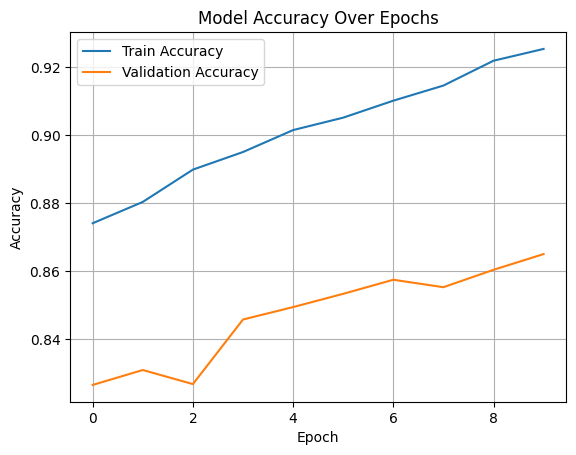

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("my_deepfake_detector.h5")